# Water Meter Reader

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/water-meter-reader.ipynb)

Click the `Open in Colab` button to run the cookbook on Google Colab.

## Install required packages

In this cookbook, we'll leverage two Python packages - `ultralytics` for running object detection, and `supervision` for tracking, visualizing detections, and crucially, detect number only in number zone.

In [1]:
!pip install -q ultralytics
!pip install -q supervision
!pip install -q gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.3 MB/s eta 0:00:00


## Imports

In [2]:
from ultralytics import YOLO
import supervision as sv
import matplotlib.pyplot as plt
import cv2
import numpy as np
import gdown


### 🏷️ Initilize Supervision's BoundingBox and Label Annotators

In [3]:
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator(text_scale=1.0,
                                    text_thickness = 3,
                                    text_padding =10)

#  YOLOv8 Model Initialization for Water Meter Detection

To facilitate water meter detection tasks, we are initializing two YOLOv8 models with specific weights. The first model, named "Water-Meter-Reader," is tailored for detecting and reading numbers on water meter counters. This model specializes in recognizing and extracting numerical data from water meter displays. The second model, named "Water-Meter-bbox," is designed to detect the area encompassing water meter counters. This model provides precise bounding box coordinates, which are useful for defining polygon zones around water meter installations. By utilizing these two YOLOv8 models, we aim to enhance the efficiency and accuracy of water meter detection tasks.

### ⬇️ Download Weights and Example Pictures

In [7]:
def download_file(url, output):
    gdown.download(url, output,fuzzy=True)

files = [
    ("https://drive.google.com/file/d/12BtbMrsPiACoj8GCz132fPqgqR6FNkR3/view?usp=sharing", "water-meter-reader.pt"),
    ("https://drive.google.com/file/d/1FJRfa0On-Y43ginA-0gmJHgIfOFahX60/view?usp=sharing", "water-meter-bbox.pt"),
    ("https://drive.google.com/file/d/15S0HytQ3A1V3Su560bcZR6kioBzxqbUQ/view?usp=sharing", "water_meter.jpg"),
    ("https://drive.google.com/file/d/1EpuzyAuJ5TsUSNtoKlJwQeBN4L4c9Dno/view?usp=sharing", "water_meter2.jpg"),
]

for url, output in files:
    download_file(url, output)

Downloading...
From: https://drive.google.com/uc?id=12BtbMrsPiACoj8GCz132fPqgqR6FNkR3
To: /content/water-meter-reader.pt
100%|██████████| 22.5M/22.5M [00:00<00:00, 31.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FJRfa0On-Y43ginA-0gmJHgIfOFahX60
To: /content/water-meter-bbox.pt
100%|██████████| 6.25M/6.25M [00:00<00:00, 35.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=15S0HytQ3A1V3Su560bcZR6kioBzxqbUQ
To: /content/water_meter.jpg
100%|██████████| 233k/233k [00:00<00:00, 3.73MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EpuzyAuJ5TsUSNtoKlJwQeBN4L4c9Dno
To: /content/water_meter2.jpg
100%|██████████| 37.2k/37.2k [00:00<00:00, 53.6MB/s]


In [59]:
model = YOLO("water-meter-reader.pt")
model_bbox = YOLO("water-meter-bbox.pt")

In [67]:
img_path = "water_meter2.jpg"
frame = cv2.imread(img_path)
h, w, _ = frame.shape
print(f"h {h}, w {w}")

h 640, w 640


### ⚙️ Processing Object Detection Results and Creating Polygon Zone

The following code snippet processes the object detection results and creates a polygon zone around a detected object, particularly useful for scenarios like water meter detection.


In [68]:
# Performing object detection on the image with confidence threshold and image size specified
results = model.predict(img_path, conf=0.05, imgsz=1280)
results_bbox = model_bbox.predict(img_path, conf=0.25)

# Converting the detection results into Detections objects
detections_bbox = sv.Detections.from_ultralytics(results_bbox[0])
detections = sv.Detections.from_ultralytics(results[0])

# Applying non-maximum suppression to remove overlapping bounding boxes
detections = detections.with_nms(threshold=0.2)

# Extracting bounding box coordinates for the region of interest
xmin, ymin, xmax, ymax = detections_bbox[0].xyxy.astype(int)[0]

# Creating a polygon zone based on the bounding box coordinates
polygon = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax], [xmin, ymin]])
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(w,h))

# Triggering the polygon zone to filter detections within the specified area
area = zone.trigger(detections=detections)
detections = detections[area]

# Extracting labels for the filtered detections
labels = [
    f"{model.model.names[detection[3]]}"  # Retrieving class names from the model
    for detection in detections
]

# Annotating the original frame with bounding boxes and labels
annotated_frame = box_annotator.annotate(detections=detections, scene=frame.copy())
annotated_frame = label_annotator.annotate(detections=detections, scene=annotated_frame, labels=labels)

# Drawing the polygon boundary on the annotated frame
annotated_frame = cv2.polylines(annotated_frame, [polygon], isClosed=False, color=sv.Color.RED.as_bgr(), thickness=3)


image 1/1 /content/water_meter2.jpg: 1280x1280 5 0s, 1 4, 1 5, 2 8s, 2310.0ms
Speed: 12.6ms preprocess, 2310.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1280, 1280)

image 1/1 /content/water_meter2.jpg: 640x640 1 meter, 181.9ms
Speed: 2.2ms preprocess, 181.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


#### Sorting and Displaying Object Detection Class IDs

This code snippet sorts the bounding boxes of detected objects from left to right to facilitate reading water meter numbers in a proper sequence.

1. Sorting Bounding Boxes: The np.argsort() function is used to sort the bounding boxes based on their x-coordinates (detections.xyxy[:, 0]). This rearranges the bounding boxes from left to right, ensuring they are processed in the correct order for reading water meter numbers.

2. Extracting Class IDs: After sorting, the class IDs of the detected objects are extracted using detections.class_id. These IDs represent the types of objects detected in the image.

3. Converting Class IDs to String: The extracted class IDs are converted to strings using astype(str) to facilitate concatenation.

4. Concatenating Class IDs: The class IDs are concatenated into a single string using the join() method, resulting in a continuous string of class IDs.

5. Printing Sorted Class IDs: Finally, the sorted and concatenated class IDs are printed (print(values)), providing a sequential display of the object detection class IDs, which can be useful for further analysis or processing, especially in scenarios like reading water meter numbers.

In [65]:
sorted_indices = np.argsort(detections.xyxy[:, 0])
class_id = detections.class_id[sorted_indices]
class_id_str = class_id.astype(str)
values = ''.join(class_id_str)
print(values)

00144111


### 🏷️ Visualize annotations

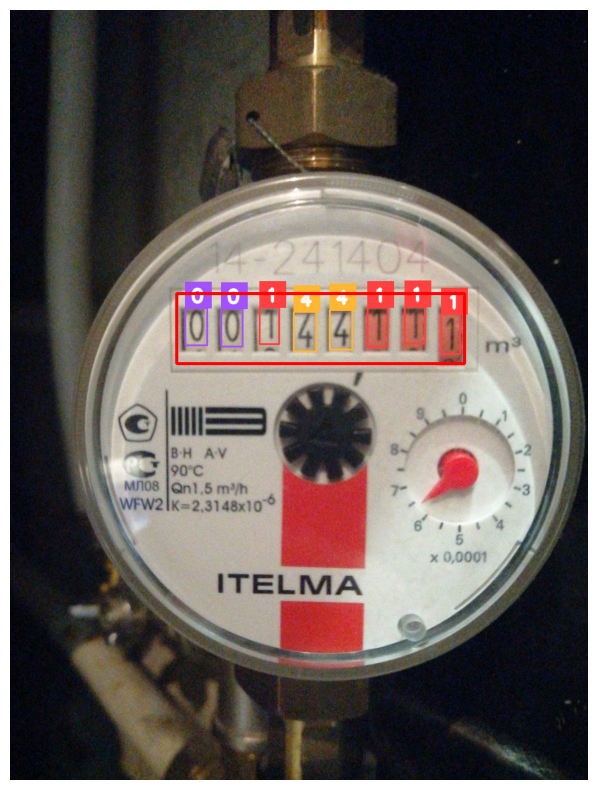

In [66]:
%matplotlib inline
sv.plot_image(annotated_frame,size=(10,10))

In [70]:
sorted_indices = np.argsort(detections.xyxy[:, 0])
class_id = detections.class_id[sorted_indices]
class_id_str = class_id.astype(str)
values = ''.join(class_id_str)
print(values)

0008854


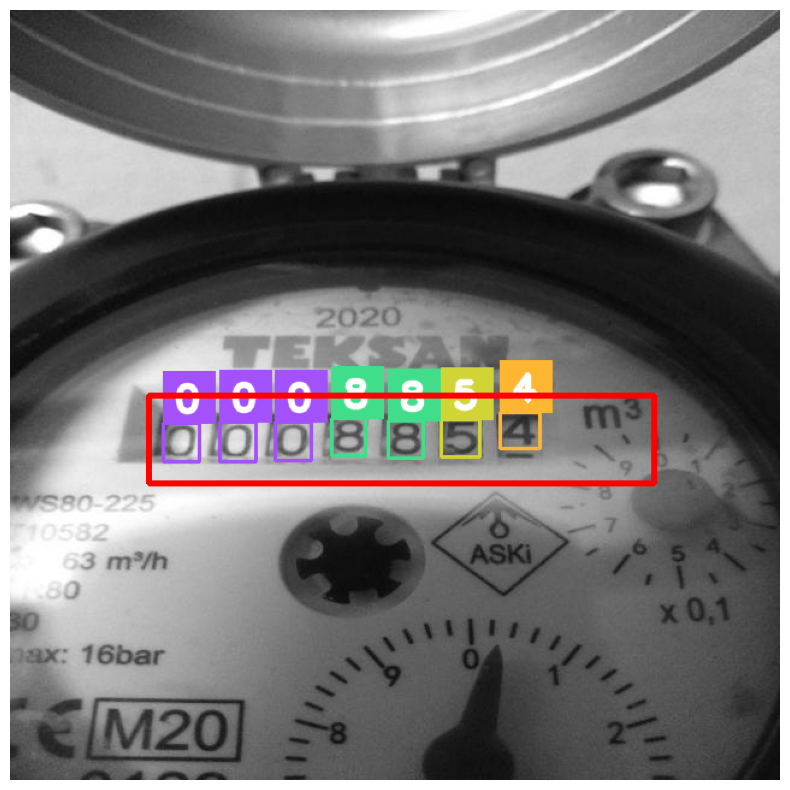

In [69]:
%matplotlib inline
sv.plot_image(annotated_frame,size=(10,10))

## 🏆 Congratulations! You read water meter counter with object detection

### Learning Resources

- [Documentation](https://supervision.roboflow.com/)
- [GitHub](https://github.com/roboflow/supervision)
- [YouTube Supervision Playlist](https://www.youtube.com/playlist?list=PLZCA39VpuaZaoGIohe9aXVMm24MRvfu1E)
- [Roboflow Universe](https://universe.roboflow.com/)